# Excess mortality across countries during the COVID-19 pandemics

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
import datetime
import statsmodels.api as sm

In [2]:
# # map
# https://geopandas.org/docs/user_guide/mapping.html
# https://stackoverflow.com/questions/64873285/winkel-tripel-projection-in-geopandas

In [3]:
import math

def round_to_n(x, n, one_digit_below_100=True):
    if x==0:
        return 0
    if np.isnan(x):
        return np.nan
    if one_digit_below_100 and np.abs(x) < 100:
        return np.round(x/10) * 10
    else:
        return round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [4]:
df = pd.read_csv('https://github.com/akarlinsky/world_mortality/blob/main/world_mortality.csv?raw=true')
# df = pd.read_csv('world_mortality.csv')

df_official_jhu = pd.read_csv('https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv?raw=true')

df_official_who = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')

df_population_wb = pd.read_csv('https://github.com/datasets/population/blob/master/data/population.csv?raw=true')

df_population_wpp = pd.read_csv('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv')
df_population_wpp = df_population_wpp[(df_population_wpp['Variant']=='Medium')&(df_population_wpp['Time']==2020)]
df_population = df_population_wpp.rename(columns={'Location':'Country Name', 'PopTotal':'Value'})
df_population['Value'] = df_population['Value'] * 1000

In [5]:
renames = {'The United Kingdom': 'United Kingdom',
           'United States of America': 'United States',
           'Bosnia and Herzegovina': 'Bosnia',
           'Republic of Korea': 'South Korea',
           'Bolivia (Plurinational State of)': 'Bolivia',
           'Iran (Islamic Republic of)': 'Iran',
           'Kosovo[1]': 'Kosovo',
           'Republic of Moldova': 'Moldova',
           'Russian Federation': 'Russia',
          
           'Korea, Rep.': 'South Korea',
           'Slovak Republic': 'Slovakia',
           'Iran, Islamic Rep.': 'Iran',
           'Czech Republic': 'Czechia',
           'Egypt, Arab Rep.': 'Egypt',
           'Hong Kong SAR, China': 'Hong Kong',
           'Kyrgyz Republic': 'Kyrgyzstan',
           'Macao SAR, China': 'Macao',
          
           'China, Hong Kong SAR':'Hong Kong',
           'China, Macao SAR': 'Macao',
           'China, Taiwan Province of China': 'Taiwan'}

for c in renames:
    df_official_who.loc[df_official_who['Country'] == c, 'Country'] = renames[c]
    df_official_jhu.loc[df_official_jhu['location'] == c, 'location'] = renames[c]
    df_population.loc[df_population['Country Name'] == c, 'Country Name'] = renames[c]
    df_population_wb.loc[df_population_wb['Country Name'] == c, 'Country Name'] = renames[c]

In [6]:
# Excess mortality calculation starts from here (year 2020)

def get_excess_begin(country, datapoints_per_year = 53):    
    if datapoints_per_year > 12:
        beg = 9  # week 10
    
    elif datapoints_per_year > 4 and datapoints_per_year <= 12:
        beg = 2  # March
        
    elif datapoints_per_year == 4:
        beg = 0 
        
    return beg

In [7]:
def predict(X, country, verbose=False):    
    # Fit regression model on pre-2020 data 
    ind = (X[:,0] < 2020) & (X[:,1]<53)
    m = np.max(X[ind,1])
    onehot = np.zeros((np.sum(ind), m))
    for i,k in enumerate(X[ind,1]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((X[ind,:1], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, X[ind,2])
        
    if verbose:
        est = sm.OLS(X[ind,2], predictors).fit()
        print(est.summary())
    
    # Compute 2020 baseline
    ind2 = X[:,0] == 2020
    predictors2020 = np.concatenate((np.ones((m,1))*2020, np.eye(m)), axis=1)
    baseline = reg.predict(predictors2020)
            
    # Week 53 usually does not have enough data, so we'll use 
    # the same baseline value as for week 52
    if np.max(X[:,1])==53:
        baseline = np.concatenate((baseline, [baseline[-1]]))
    
    # Excess mortality
    ind2 = X[:,0] == 2020
    diff2020 = X[ind2,2] - baseline[X[ind2,1]-1]
    ind3 = X[:,0] == 2021
    diff2021 = X[ind3,2] - baseline[X[ind3,1]-1]
    excess_begin = get_excess_begin(country, baseline.size)
    total_excess = np.sum(diff2020[excess_begin:]) + np.sum(diff2021)
        
    # Manual fit for uncertainty computation
    if np.unique(X[ind,0]).size > 1:
        y = X[ind,2][:,np.newaxis]
        beta = np.linalg.pinv(predictors.T @ predictors) @ predictors.T @ y
        yhat = predictors @ beta
        sigma2 = np.sum((y-yhat)**2) / (y.size-predictors.shape[1])
        
        S = np.linalg.pinv(predictors.T @ predictors)
        w = np.zeros((m, 1))
        w[X[(X[:,0] == 2020) & (X[:,1] < 53),1]-1] = 1
#         if np.max(X[:,1])==53:
        if np.sum((X[:,0] == 2020) & (X[:,1] == 53)) > 0:
            w[52-1] += 1
        w[:excess_begin] = 0
        w[X[ind3,1]-1] += 1
        
        p = 0
        for i,ww in enumerate(w):
            p += predictors2020[i] * ww
        p = p[:,np.newaxis]
                        
        predictive_var = sigma2 * np.sum(w) + sigma2 * p.T @ S @ p
        total_excess_std = np.sqrt(predictive_var)[0][0]
    else:
        total_excess_std = np.nan
       
    return baseline, total_excess, excess_begin, total_excess_std

In [8]:
countries = np.unique(df['country_name'])
print(f'Total countries: {countries.size}')

allcountries = {}

heatwave_excess = np.zeros(countries.size)

for i, country in enumerate(countries):    
    print('.', end='')
        
    assert(np.unique(df[(df['country_name']==country)]['time_unit']).size == 1)
    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
      
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    # https://en.wikipedia.org/wiki/Casualties_of_the_2020_Nagorno-Karabakh_war
    if country=='Armenia':
        total_excess -= 4000 # 3360
    if country=='Azerbaijan':
        total_excess -= 4000 # (2854+50)
        
    # August 2020 heatwave, weeks 32-34
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany']:
        heatwave = np.sum(X[(X[:,0]==2020)&(X[:,1]>=32)&(X[:,1]<=34), 2])
        heatwave -= np.sum(baseline[32-1:34+1-1])
        total_excess -= heatwave
        heatwave_excess[i] = heatwave
        
    allcountries[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

Total countries: 111
...............................................................................................................

In [9]:
# Heat wave deaths (weeks 32-34)

for i, country in enumerate(countries):
    if heatwave_excess[i] > 0:
        print(f'{country:12} -- {heatwave_excess[i]:.0f}')

Belgium      -- 1526
France       -- 1545
Germany      -- 4256
Luxembourg   -- 31
Netherlands  -- 663


In [10]:
# Countries with data not from 2015 but later

for c in allcountries:
    if allcountries[c][0][0][0] != 2015:
        print(f'{c:17} -- data start with {allcountries[c][0][0][0]}')

Chile             -- data start with 2016
Peru              -- data start with 2017
Transnistria      -- data start with 2016


In [11]:
# Export the baselines

with open('baselines.csv','w') as f:
    for c in allcountries:
        X, baseline, total_excess, excess_begin, total_excess_std = allcountries[c] 
        for i,b in enumerate(baseline):
            f.write(f'{c}, {i+1}, {b:.1f}\n')

In [12]:
# Export the excess time series

with open('excess-mortality-timeseries.csv', 'w') as f:
    f.write('country_name,year,time,time_unit,excess deaths\n')

    for c in allcountries:
        X, baseline, total_excess, excess_begin, total_excess_std = allcountries[c] 
        if baseline.size == 4:
            units = 'quarterly'
        elif baseline.size == 12:
            units = 'monthly'
        else:
            units = 'weekly'
        
        ind = X[:,0] == 2020
        for num,Xrow in enumerate(X[ind]):
            f.write(f'{c},2020,{Xrow[1]},{units},{Xrow[2]-baseline[num]:.1f}\n')
        
        ind = X[:,0] == 2021
        for num,Xrow in enumerate(X[ind]):
            f.write(f'{c},2021,{Xrow[1]},{units},{Xrow[2]-baseline[num]:.1f}\n')

In [13]:
# Population

pops = np.zeros(len(allcountries.keys()))
for i,m in enumerate(allcountries.keys()):
    # Russia's population should include Crimea because mortality figures do 
    # Ukraine's population should *not* include Crimea
    if m=='Russia':
        pops[i] = 146748590 # Rosstat, estimate for 1 Jan 2020    
    elif m=='Ukraine':
        pops[i] = 41762138  # Ukrstat 2020, according to Wikipedia
    elif m=='Transnistria':
        pops[i] = 465200    # NSO
    elif m=='Kosovo':
        pops[i] = df_population_wb[df_population_wb['Country Name']==m]['Value'].values[-1]
    else:
        pops[i] = df_population[df_population['Country Name']==m]['Value'].values[-1]
        
pops[countries=='Serbia'] = pops[countries=='Serbia'] - pops[countries=='Kosovo']

In [14]:
# Daily reported numbers during the same time period

official = np.zeros(len(allcountries.keys()))
officialnow = np.zeros(len(allcountries.keys()))

for i,m in enumerate(allcountries.keys()):
    howmany = np.max(allcountries[m][0][:,1])
    last = allcountries[m][0][-1][1]
    lastyear = allcountries[m][0][-1][0]
    
    if howmany > 12:
        d = f'{lastyear}-W{last:02}'
        r = datetime.datetime.strptime(d + '-0', "%G-W%V-%w")
        r = str(r)[:10]
    elif howmany > 4:
        if last < 12:
            r = f'{lastyear}-{last+1:02}-01'
        else:
            r = f'{lastyear+1}-01-01'
    elif howmany == 4:
#         if m == 'Iran':
#             https://twitter.com/Mahan_Ghafari/status/1336338070249951236
#             r = '2021-06-21'
#         else:
        if last < 4:
            r = f'{lastyear}-{last*3+1:02}-01'
        else:
            r = f'{lastyear+1}-01-01'
    else:
        r = ''

    # temporary fix
    if m == 'Russia':
        r = '2021-10-31'
        
    if m == 'Transnistria':
        # From the Telegram channel https://t.me/novostipmrcom
        # End of 2019: 473
        # January: 626
        # February: 689
        # March: 907
        # April: 1112
        # May: 1195
        # June: 1219
        # July: 1246
        # August: 1273
        # September: 1345
        # October: 1532
        official[i] = 1532 
        continue
        
    if m in ['Taiwan', 'Macao', 'Hong Kong']:
        official[i] = df_official_jhu[(df_official_jhu['location']==m)
                                      &(df_official_jhu['date']==r)]['total_deaths'].values[0]
        officialnow[i] = df_official_jhu[(df_official_jhu['location']==m)]['total_deaths'].values[-1]
        if np.isnan(official[i]):
            official[i] = 0
        if np.isnan(officialnow[i]):
            officialnow[i] = 0
    else:
        official[i] = df_official_who[(df_official_who['Country']==m)
                                  &(df_official_who['Date_reported']==r)]['Cumulative_deaths'].values[0]
        officialnow[i] = df_official_who[(df_official_who['Country']==m)]['Cumulative_deaths'].values[-1]

In [15]:
# Sum over the entire dataset

totalexcess = 0
for c in allcountries:
    totalexcess += allcountries[c][2]
    
print(f'Total excess: {totalexcess:,.0f}')
print(f'Official Covid deats: {np.nansum(official):,.0f}')
print(f'Ratio: {totalexcess / np.nansum(official) :.2f}')

Total excess: 6,002,258
Official Covid deats: 3,830,331
Ratio: 1.57


In [16]:
zs = np.zeros(countries.size)
for i,c in enumerate(allcountries):
    zs[i] = allcountries[c][2]/allcountries[c][4]

print(f'Statistically significant increase:  {np.sum(zs>2)}')      
print(f'Statistically significant decrease:  {np.sum(zs<-2)}')      
print(f'Not statistically significant:       {np.sum(np.abs(zs)<2)}')      
print(f'Impossible to assess significance:   {np.sum(np.isnan(zs))}')      

Statistically significant increase:  83
Statistically significant decrease:  1
Not statistically significant:       27
Impossible to assess significance:   0


In [17]:
baselinelengths = np.zeros(countries.size)
for i,c in enumerate(allcountries):
    baselinelengths[i] = allcountries[c][1].size

print(f'Weekly data: {np.sum(baselinelengths>50)}')
print(f'Monthly data: {np.sum((baselinelengths<50) & (baselinelengths>4))}')
print(f'Quarterly data: {np.sum(baselinelengths==4)}')

Weekly data: 51
Monthly data: 59
Quarterly data: 1


## Figures

In [18]:
def stairs(x,y):
    xx = []
    yy = []
    for i in range(x.size):
        if i>0 and x[i]-x[i-1] > 1:
            skip = (x[i]-x[i-1]) - 1
            xx = xx + [np.nan, np.nan] * skip
            yy = yy + [np.nan, np.nan] * skip
        xx = xx + [x[i]-.5, x[i]+.5]
        yy = yy + [y[i], y[i]]
    return xx, yy

In [19]:
def percent_increase(country, zero_not_signif=False):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    d = total_excess/np.sum(baseline)*100
    
    if zero_not_signif and np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000 # for alphabetical sorting
    return d

In [20]:
undercounts = np.zeros(countries.size)
for i,country in enumerate(countries):
    if allcountries[country][2]/np.sum(allcountries[country][1])*100 < 2:
        undercounts[i] = np.nan
    else:
        undercounts[i] = allcountries[country][2] / official[i]

undercounts[np.isin(countries, ['Hong Kong', 'Cuba', 'Bermuda', 'Antigua and Barbuda',
                                'Finland', 'Cyprus', 'Iceland', 'Japan', 'Singapore',
                                'Denmark'])] = np.nan

<IPython.core.display.Javascript object>


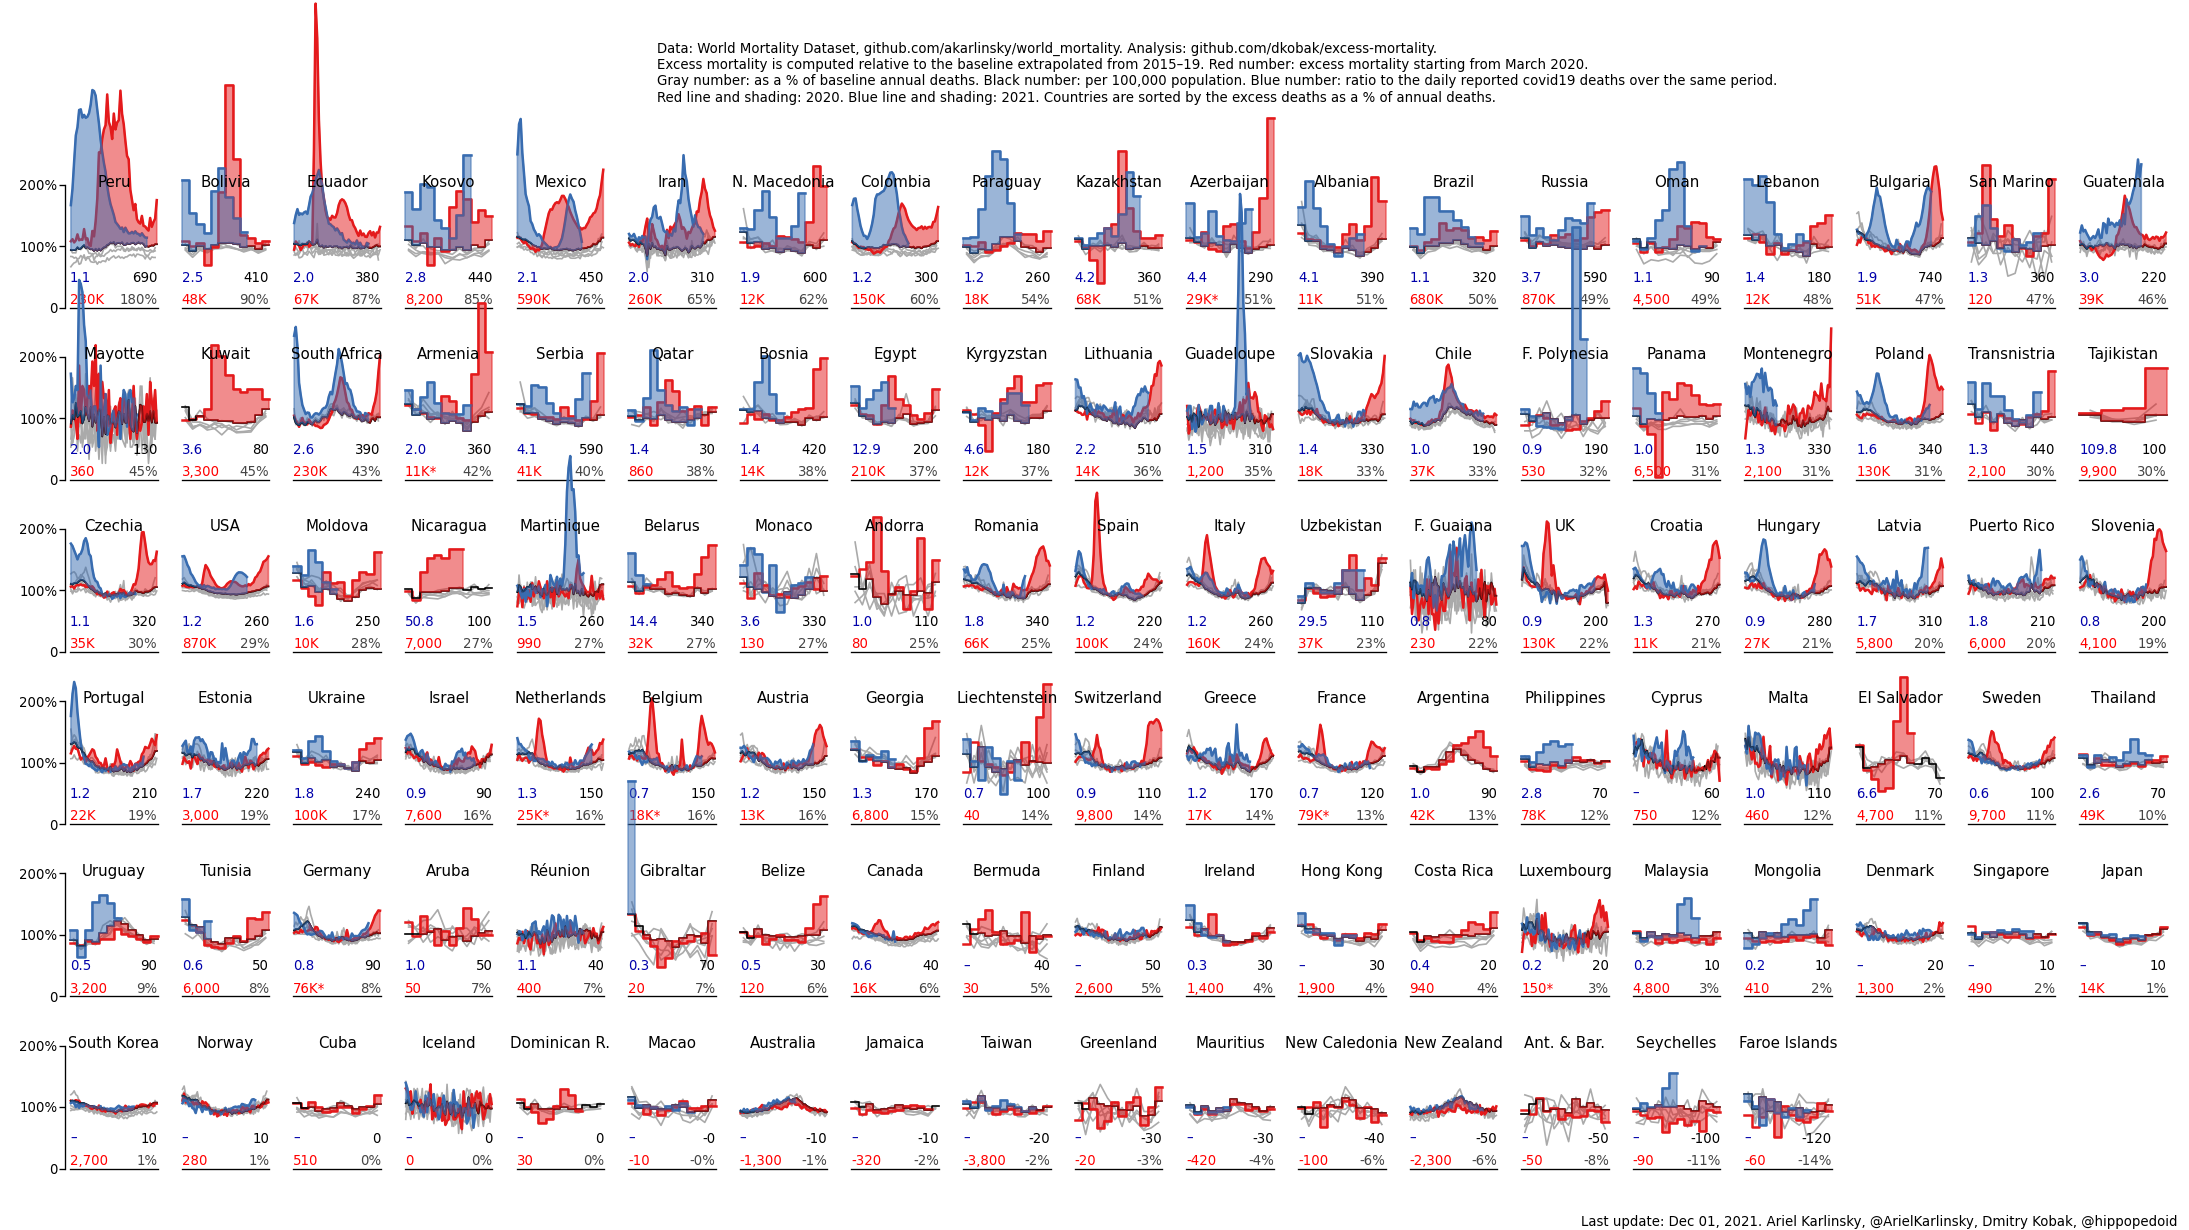

In [21]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    ds[i] = percent_increase(country, zero_not_signif=False)
ind = np.argsort(ds)[::-1]

thresh = 0

fig = plt.figure(figsize=(8*1.9,4.5*1.9))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    ax = plt.axes([.032+(i%19)*.051, .75-np.floor(i/19)*.14, .04, .1])
    
    col2020 = '#e41a1c' 
    col2021 = '#386cb0'
    alpha = .5
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
        
    if baseline.size < 50:
        xx1,yy1 = stairs(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2])
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)
    
        if np.sum(X[:,0]==2021)>0:
            xx3,yy3 = stairs(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2])
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)

        xx2,yy2 = stairs(np.arange(baseline.size)+1, baseline)
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
    else:
        xx1,yy1 = X[X[:,0]==2020, 1], X[X[:,0]==2020, 2]
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)

        if np.sum(X[:,0]==2021)>1:
            xx3,yy3 = X[X[:,0]==2021, 1], X[X[:,0]==2021, 2]
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)
        elif np.sum(X[:,0]==2021)==1:
            plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color=col2021, markersize=3, clip_on=False)
        plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

        xx2,yy2 = np.arange(baseline.size)+1, baseline
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
        
    toplabel = .3
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
        if np.abs(total_excess) > 10000:
            plt.text(.0, .03, f'{round_to_n(total_excess,2)/1000:,.0f}K'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)    
        else:
            plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{percent_increase(country):.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[ind][i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if ~np.isnan(undercounts[ind][i]):
            plt.text(.0, toplabel, f'{undercounts[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '–', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    if baseline.size < 50:
        poly1 = np.concatenate((xx1[excess_begin*2:], xx1[excess_begin*2:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin*2:], yy2[:len(yy1)][excess_begin*2:][::-1]))
    else:
        poly1 = np.concatenate((xx1[excess_begin:], xx1[excess_begin:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin:], yy2[:len(yy1)][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=alpha, zorder=5, clip_on=False)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021) > 1 or (baseline.size < 50 and np.sum(X[:,0]==2021) > 0):
        poly1 = np.concatenate((xx3, xx3[::-1]))
        poly2 = np.concatenate((yy3[:len(yy3)], yy2[:len(yy3)][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor=col2021, edgecolor=col2021, alpha=alpha, zorder=5, clip_on=False)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,2*np.mean(baseline)])
    plt.xlim([.5, baseline.size+.5])
    plt.xticks([])
    
    shorten = {'North Macedonia': 'N. Macedonia',
               'United Kingdom': 'UK',
               'French Polynesia': 'F. Polynesia',
               'United States': 'USA',
               'French Guiana': 'F. Guaiana',
               'Antigua and Barbuda': 'Ant. & Bar.',
               'Dominican Republic': 'Dominican R.'}
    plt.title(shorten[country] if country in shorten else country, 
              fontsize=9, y=.9, zorder=100)
        
    if i%19 > 0:
        plt.yticks([])
        sns.despine(left=True, ax=ax)
    else:
        plt.yticks([0,np.mean(baseline),np.mean(baseline)*2], ['0', '100%', '200%'], fontsize=7)
        sns.despine(ax=ax, offset={'left':3})
        plt.gca().set_yticklabels(['0', '100%', '200%'], fontsize=8)
        plt.gca().yaxis.set_tick_params(pad=1)

fig.text(.3, .915, 
'Data: World Mortality Dataset, github.com/akarlinsky/world_mortality. '
'Analysis: github.com/dkobak/excess-mortality.\n'
'Excess mortality is computed relative to the baseline extrapolated from 2015–19. '
'Red number: excess mortality starting from March 2020.\n'
'Gray number: as a % of baseline annual deaths. '
'Black number: per 100,000 population. '
'Blue number: ratio to the daily reported covid19 deaths over the same period.\n'
'Red line and shading: 2020. Blue line and shading: 2021. Countries are sorted '
'by the excess deaths as a % of annual deaths.',
         fontsize=8, va='bottom')

fig.text(.995,.001, f'Last update: {datetime.date.today():%b %d, %Y}. '
         'Ariel Karlinsky, @ArielKarlinsky, Dmitry Kobak, @hippopedoid', 
         fontsize=8, ha='right', va='bottom')

plt.savefig('img/all-countries.png', dpi=200)

<IPython.core.display.Javascript object>


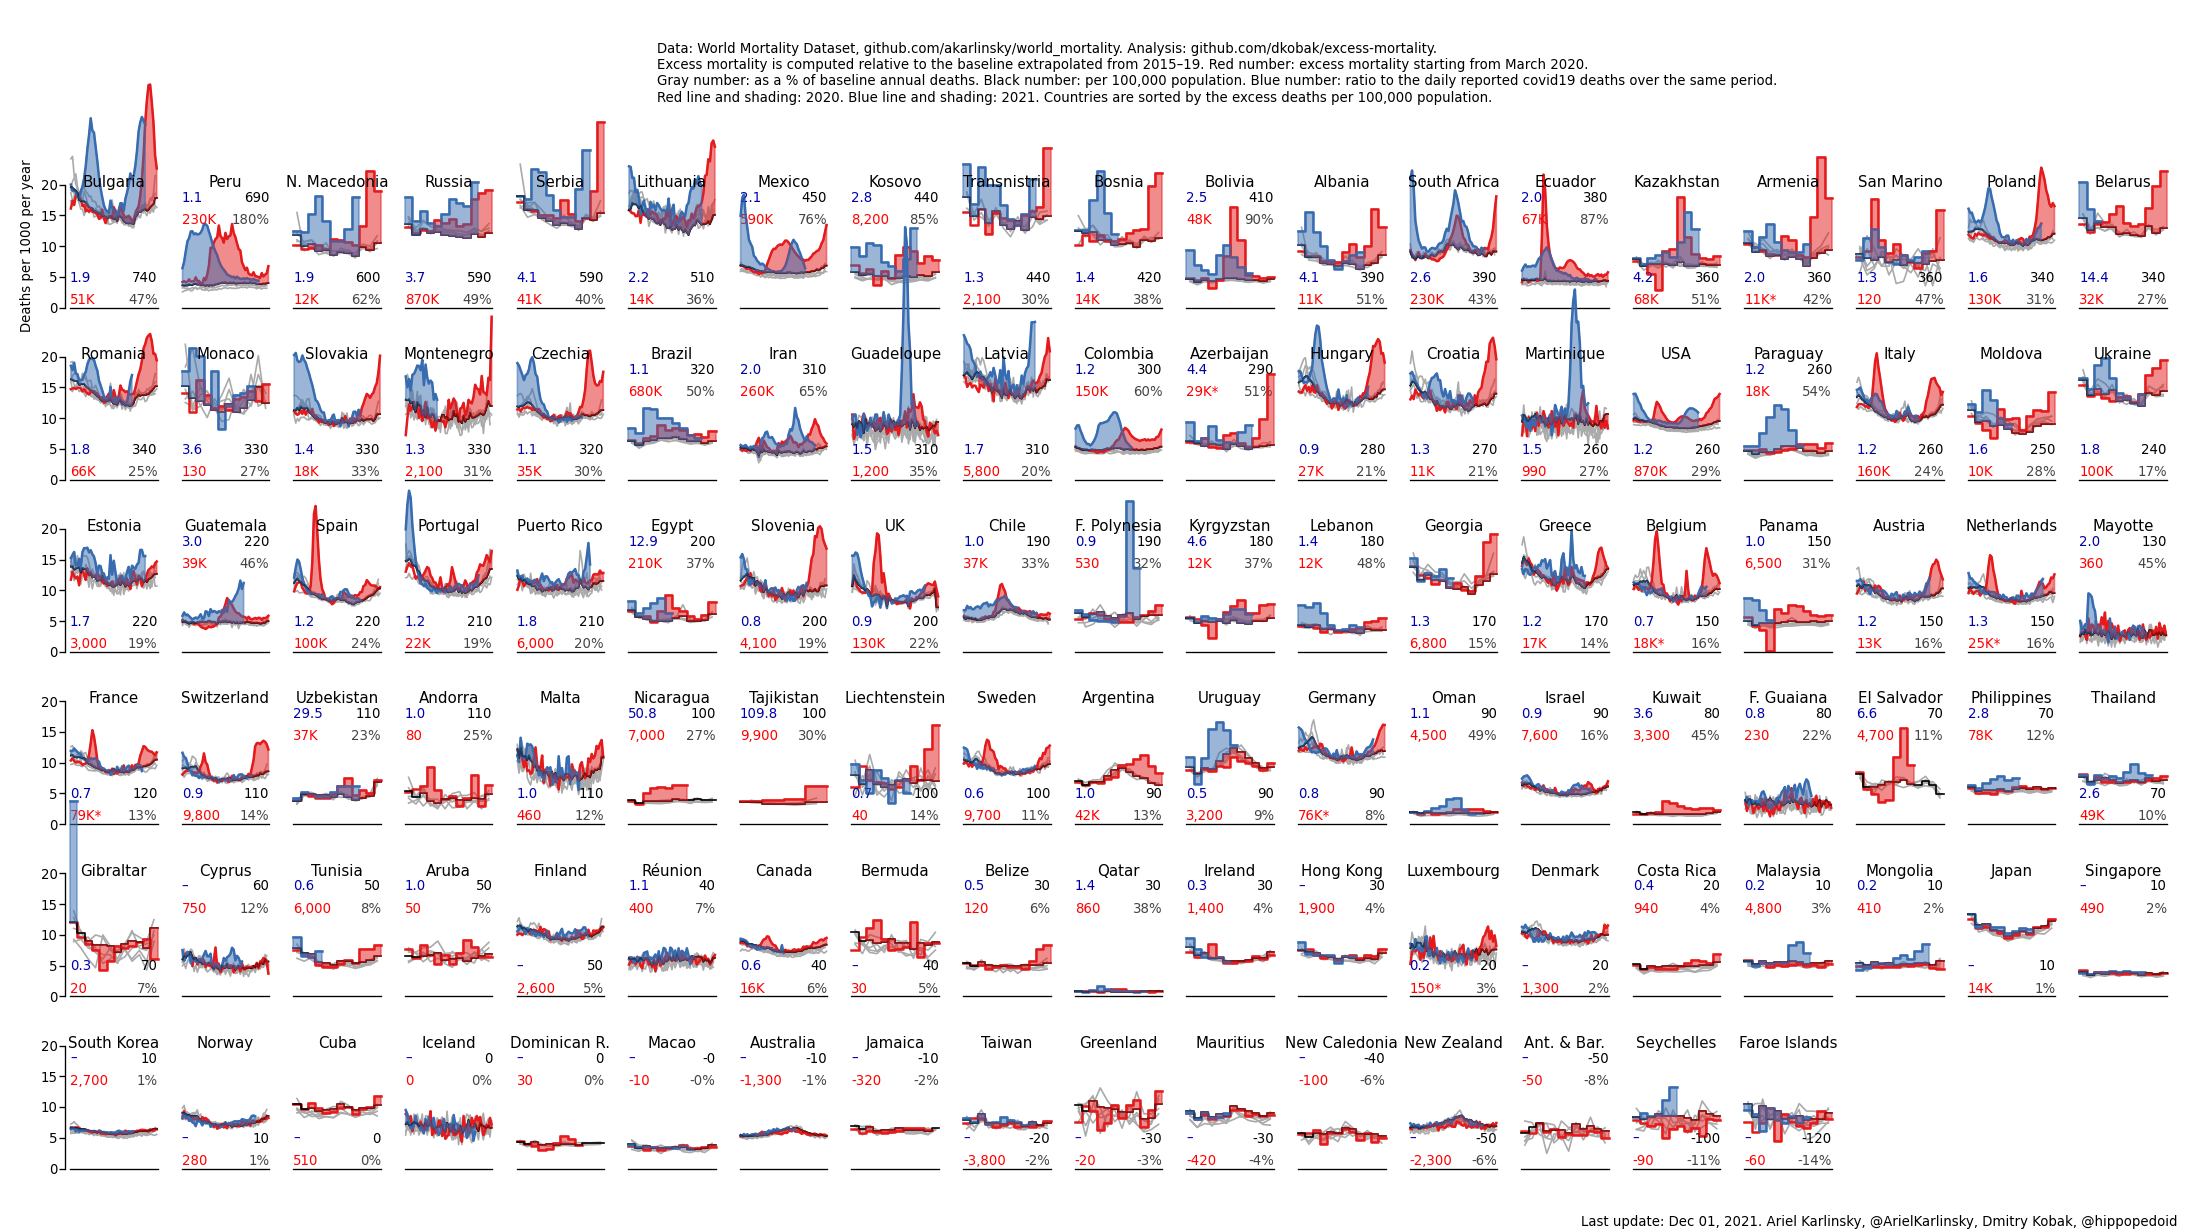

In [22]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    ds[i] = total_excess/pops[i]
ind = np.argsort(ds)[::-1]

thresh = 0

fig = plt.figure(figsize=(8*1.9,4.5*1.9))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    ax = plt.axes([.032+(i%19)*.051, .75-np.floor(i/19)*.14, .04, .1])
    
    col2020 = '#e41a1c'
    col2021 = '#386cb0'
    alpha = .5
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    X = X.copy().astype(float)
    baseline = baseline.copy()
    X[:,2] = X[:,2] / pops[ind][i] * 1000 * baseline.size
    baseline = baseline / pops[ind][i] * 1000 * baseline.size

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
        
    if baseline.size < 50:
        xx1,yy1 = stairs(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2])
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)
    
        if np.sum(X[:,0]==2021)>0:
            xx3,yy3 = stairs(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2])
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)

        xx2,yy2 = stairs(np.arange(baseline.size)+1, baseline)
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
    else:
        xx1,yy1 = X[X[:,0]==2020, 1], X[X[:,0]==2020, 2]
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)

        if np.sum(X[:,0]==2021)>1:
            xx3,yy3 = X[X[:,0]==2021, 1], X[X[:,0]==2021, 2]
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)
        elif np.sum(X[:,0]==2021)==1:
            plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color=col2021, markersize=3, clip_on=False)
        plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

        xx2,yy2 = np.arange(baseline.size)+1, baseline
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
        
    if np.mean(baseline) > 7:
        toplabel = .3
        bottomlabel = .03
    else:
        toplabel = .95
        bottomlabel = .68
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
        if np.abs(total_excess) > 10000:
            plt.text(.0, bottomlabel, f'{round_to_n(total_excess,2)/1000:,.0f}K'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)    
        else:
            plt.text(.0, bottomlabel, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, bottomlabel, f'{percent_increase(country):.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[ind][i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if ~np.isnan(undercounts[ind][i]):
            plt.text(.0, toplabel, f'{undercounts[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '–', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, bottomlabel, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
                
    if baseline.size < 50:
        poly1 = np.concatenate((xx1[excess_begin*2:], xx1[excess_begin*2:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin*2:], yy2[:len(yy1)][excess_begin*2:][::-1]))
    else:
        poly1 = np.concatenate((xx1[excess_begin:], xx1[excess_begin:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin:], yy2[:len(yy1)][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=alpha, zorder=5, clip_on=False)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021) > 1 or (baseline.size < 50 and np.sum(X[:,0]==2021) > 0):
        poly1 = np.concatenate((xx3, xx3[::-1]))
        poly2 = np.concatenate((yy3[:len(yy3)], yy2[:len(yy3)][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor=col2021, edgecolor=col2021, alpha=alpha, zorder=5, clip_on=False)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,20])
    plt.xlim([.5, baseline.size+.5])
    plt.xticks([])
    
    shorten = {'North Macedonia': 'N. Macedonia',
               'United Kingdom': 'UK',
               'French Polynesia': 'F. Polynesia',
               'United States': 'USA',
               'French Guiana': 'F. Guaiana',
               'Antigua and Barbuda': 'Ant. & Bar.',
               'Dominican Republic': 'Dominican R.'}
    plt.title(shorten[country] if country in shorten else country, 
              fontsize=9, y=.9, zorder=100)
        
    if i%19 > 0:
        plt.yticks([])
        sns.despine(left=True, ax=ax)
    else:
        plt.yticks([0,5,10,15,20], fontsize=7)
        sns.despine(ax=ax, offset={'left':3})
        plt.gca().set_yticklabels([0,5,10,15,20], fontsize=8)
        plt.gca().yaxis.set_tick_params(pad=1)
        
    if i==0:
        plt.ylabel('Deaths per 1000 per year', fontsize=8)

fig.text(.3, .915, 
'Data: World Mortality Dataset, github.com/akarlinsky/world_mortality. '
'Analysis: github.com/dkobak/excess-mortality.\n'
'Excess mortality is computed relative to the baseline extrapolated from 2015–19. '
'Red number: excess mortality starting from March 2020.\n'
'Gray number: as a % of baseline annual deaths. '
'Black number: per 100,000 population. '
'Blue number: ratio to the daily reported covid19 deaths over the same period.\n'
'Red line and shading: 2020. Blue line and shading: 2021. Countries are sorted '
'by the excess deaths per 100,000 population.',
         fontsize=8, va='bottom')

fig.text(.995,.001, f'Last update: {datetime.date.today():%b %d, %Y}. '
         'Ariel Karlinsky, @ArielKarlinsky, Dmitry Kobak, @hippopedoid', 
         fontsize=8, ha='right', va='bottom')

plt.savefig('img/all-countries-per1000.png', dpi=200)

In [23]:
def until_date(country):
    howmany = np.max(allcountries[country][0][:,1])
    last = allcountries[country][0][-1][1]
    lastyear = allcountries[country][0][-1][0]

    if howmany>12:
        date = datetime.datetime.strptime(f'{lastyear}-W{last:02}-0', "%G-W%V-%w")
    elif howmany>4:
        if last<12:
            date = datetime.datetime.strptime(f'{lastyear}-{last+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
    else:
        if last<4:
            date = datetime.datetime.strptime(f'{lastyear}-{last*3+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
        
        if country=='Iran':
            if last>1:
                date = datetime.datetime.strptime(f'{lastyear}-{last*3:02}-21', "%Y-%m-%d")
            else:
                date = datetime.datetime.strptime(f'{lastyear-1}-12-21', "%Y-%m-%d")

    date = date.strftime('%b %d, %Y')
    
    if howmany>12:
        time_format = 'w'
    elif howmany>4:
        time_format = 'm'
    else:
        time_format = 'q'
    
    return date, time_format
    

print('Country                     Until  Type   Confirmed      Excess      std      z  Undercount  Per 100k   Increase')
print('----------------------------------------------------------------------------------------------------------------')

for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 0
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        if ~np.isnan(undercounts[i]) and allcountries[c][2] > 0:
            undercount = f'       {undercounts[i]:5.1f}' 
        else:
            undercount = '         ---'
        per100k    = f'      {round_to_n(allcountries[c][2]/pops[i]*1e+5,2):4.0f}'
        increase   = f'       {percent_increase(c):3.0f}%'

    else:
        undercount = ''
        per100k    = ''
        increase   = ''
    
    print(f'{c:20} {until:15}  {time_format}     {round_to_n(official[i],2):7,.0f}'
          f'     {round_to_n(allcountries[c][2],2):7,.0f} ± {round_to_n(allcountries[c][4],2):6,.0f}' 
          f'  {z:5.1f}' + undercount + per100k + increase)

Country                     Until  Type   Confirmed      Excess      std      z  Undercount  Per 100k   Increase
----------------------------------------------------------------------------------------------------------------
Albania              Sep 30, 2021     m       2,700      11,000 ±  1,100   10.1         4.1       390        51%
Andorra              Dec 31, 2020     m          80          80 ±     30    3.1         1.0       110        25%
Antigua and Barbuda  Dec 31, 2020     m           0         -50 ±     40    1.2         ---       -50        -8%
Argentina            Dec 31, 2020     m      43,000      42,000 ±  6,400    6.6         1.0        90        13%
Armenia              Sep 30, 2021     m       5,300      11,000 ±  1,100   10.0         2.0       360        42%
Aruba                Dec 31, 2020     m          50          50 ±     30    1.5         1.0        50         7%
Australia            Aug 29, 2021     w         990      -1,300 ±  1,300    1.0         ---     

In [24]:
for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 0
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        if ~np.isnan(undercounts[i]) and allcountries[c][2] > 0:
            undercount = f'{undercounts[i]:.1f}' 
        else:
            undercount = '--'
        
        per100k    = f'${round_to_n(allcountries[c][2]/pops[i]*1e+5,2):.0f}$'
        increase   = f'${percent_increase(c):.0f}\%$'

    else:
        undercount = 'n.s.'
        per100k    = 'n.s.'
        increase   = 'n.s.'
        
    minus = '$-$' if allcountries[c][2]<0 else ''
    
    print(f'{c} & {until} & {time_format} & {round_to_n(official[i],2):,.0f} & '
          '' + minus + f'{round_to_n(np.abs(allcountries[c][2]),2):,.0f}'
          f'& $\pm\,${round_to_n(allcountries[c][4],2):,.0f} & ' 
          f'{z:.1f}' + ' & ' + undercount + ' & '  + per100k + ''
          ' & ' + increase + '\\\\')

Albania & Sep 30, 2021 & m & 2,700 & 11,000& $\pm\,$1,100 & 10.1 & 4.1 & $390$ & $51\%$\\
Andorra & Dec 31, 2020 & m & 80 & 80& $\pm\,$30 & 3.1 & 1.0 & $110$ & $25\%$\\
Antigua and Barbuda & Dec 31, 2020 & m & 0 & $-$50& $\pm\,$40 & 1.2 & -- & $-50$ & $-8\%$\\
Argentina & Dec 31, 2020 & m & 43,000 & 42,000& $\pm\,$6,400 & 6.6 & 1.0 & $90$ & $13\%$\\
Armenia & Sep 30, 2021 & m & 5,300 & 11,000& $\pm\,$1,100 & 10.0 & 2.0 & $360$ & $42\%$\\
Aruba & Dec 31, 2020 & m & 50 & 50& $\pm\,$30 & 1.5 & 1.0 & $50$ & $7\%$\\
Australia & Aug 29, 2021 & w & 990 & $-$1,300& $\pm\,$1,300 & 1.0 & -- & $-10$ & $-1\%$\\
Austria & Nov 14, 2021 & w & 11,000 & 13,000& $\pm\,$1,800 & 7.6 & 1.2 & $150$ & $16\%$\\
Azerbaijan & Sep 30, 2021 & m & 6,500 & 29,000& $\pm\,$2,000 & 14.4 & 4.4 & $290$ & $51\%$\\
Belarus & Mar 31, 2021 & m & 2,200 & 32,000& $\pm\,$2,000 & 16.0 & 14.4 & $340$ & $27\%$\\
Belgium & Nov 14, 2021 & w & 26,000 & 18,000& $\pm\,$2,300 & 7.7 & 0.7 & $150$ & $16\%$\\
Belize & Dec 31, 2020 & m & 2

In [25]:
# Export the table

with open('excess-mortality.csv','w') as f:
    f.write('Country,Data until,Data type,COVID-19 deaths,Excess deaths,'
            'Excess deaths std,t-statistic,Undercount ratio,Excess per 100k,'
            'Excess as % of annual baseline\n')
    
    for i,c in enumerate(allcountries):
        until, time_format = until_date(c)
         
        per100k    = allcountries[c][2]/pops[i]*1e+5
        increase   = percent_increase(c)
        
        z = np.abs(allcountries[c][2])/allcountries[c][4]
            
        f.write(f'{c},"{until}",{time_format},{official[i]:.0f},{allcountries[c][2]:.0f},'
                f'{allcountries[c][4]:.0f},{z:.1f},{undercounts[i]:.2f},{per100k:.1f},{increase:.1f}\n')

In [26]:
# # Placeholder to look stuff up

# country = 'Bermuda'

# X,baseline,_,_,_ = allcountries[country] 
# plt.figure(figsize=(5,3))
# for year in np.arange(X[0,0],2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], lw=1, label=year) #color='#aaaaaa')
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=1.5, clip_on=False, label=2021)
# plt.plot(X[X[:,0]==2020, 1][get_excess_begin(country, baseline.size):], 
#          X[X[:,0]==2020, 2][get_excess_begin(country, baseline.size):], '.', color='r', lw=1.5, clip_on=False)
# plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, label='baseline')

# for year in np.arange(X[0,0],2021):
#     print(np.sum(X[X[:,0]==year, 2]))

# # beg = excess_begin(country)
# # d = np.sum(diff[10:21])
# # d

# plt.title(country)

# plt.legend(fontsize=8)

# sns.despine()
# plt.tight_layout()
# # plt.savefig('img/swe.png', dpi=100)

# # (X[X[:,0]==2020, 2] - baseline)

In [27]:
# # df = pd.read_csv('https://data.cdc.gov/api/views/y5bj-9g5w/rows.csv')
# d = df[(df['Jurisdiction']=='New York City') & (df['Type']=='Predicted (weighted)')].groupby(['Year','Week']).sum().values
# y = df[(df['Jurisdiction']=='New York City') & (df['Type']=='Predicted (weighted)')&(df['Age Group']=='25-44 years')][['Year', 'Week']].values
# X = np.concatenate((y,d), axis=1)

In [28]:
# col2020 = '#e41a1c'
# col2021 = '#386cb0'
    
# plt.figure(figsize=(8*.75,4.5*.75))

# plt.subplot(121)

# mean = np.zeros(52)
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
#     mean += X[X[:,0]==year, 2]
# mean /= 5
# mean = np.concatenate((mean, [mean[-1]]))
# # plt.plot(np.arange(mean.size)+1, mean, 'k')
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color=col2020, lw=1.5, clip_on=False)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color=col2021, lw=1.5, clip_on=False)
# plt.xlim([1,53])
# plt.ylim([0,8000])
# plt.title('New York City')
# plt.xlabel('Week')
# plt.ylabel('Deaths per week')

# sns.despine()
# plt.tight_layout()

# np.sum((X[X[:,0]==2020, 2] - mean)[10:]) + np.sum((X[X[:,0]==2021, 2] - mean[:np.sum(X[:,0]==2021)]))

<IPython.core.display.Javascript object>


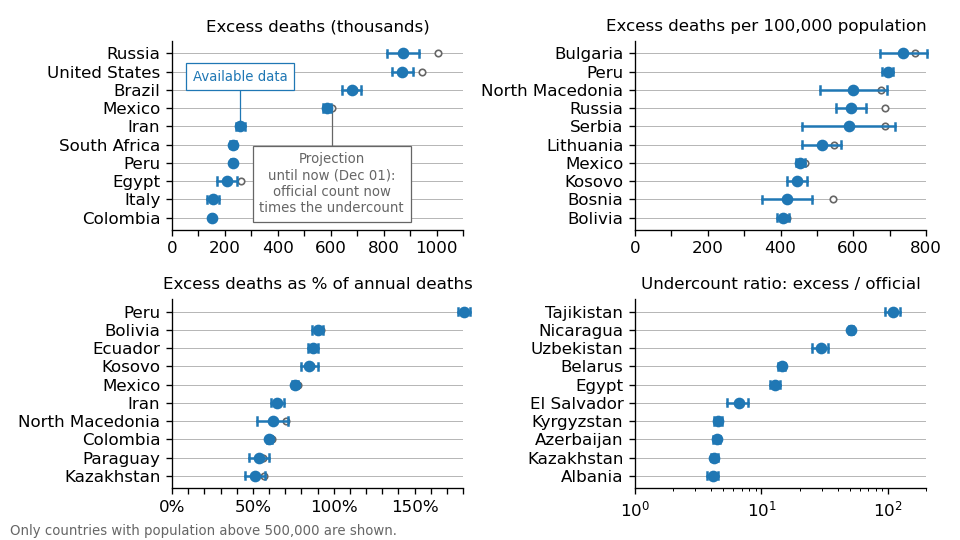

In [29]:
fig = plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / 1000
    z[i] = allcountries[c][4] / 1000 * 1.96
    y[i] = x[i] / (official[i]+.001) * officialnow[i]
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,1100] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000,1100],
           ['0', '', '200', '', '400', '', '600', '', '800', '', '1000',''])
plt.title('Excess deaths (thousands)', fontsize=10)

plt.text(y[ind][3],-8.7, f'Projection\nuntil now ({datetime.date.today():%b %d}):\n'
                         'official count now\ntimes the undercount', color='#666666', 
         fontsize=8, ha='center', bbox=dict(facecolor='w', edgecolor='#666666', lw=.75))
plt.plot([y[ind][3],y[ind][3]], [-8,-3], lw=.75, color='#666666',zorder=.1)
plt.text(x[ind][4],-1.5, 'Available data', color=sc.get_facecolors()[0], 
         fontsize=8, ha='center', bbox=dict(facecolor='w', edgecolor=sc.get_facecolors()[0], lw=.75))
plt.plot([x[ind][4],x[ind][4]], [-4,-2], lw=.75, color=sc.get_facecolors()[0],zorder=.1)

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / (official[i]+.001)
    z[i] = allcountries[c][4] / (official[i]+.001)
    if np.isnan(undercounts[i]):#allcountries[c][2]/allcountries[c][4] < 2:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [1,200] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official', fontsize=10)
plt.xscale('log')

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / pops[i] * 1e+5
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    z[i] = allcountries[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,800]
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600,700,800],
           ['0','','200','','400','','600','','800'])
plt.title('Excess deaths per 100,000 population', x=.45, fontsize=10)

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = percent_increase(c)
    z[i] = allcountries[c][4] / np.sum(allcountries[c][1]) * 100 * 1.96 ### DANGER ####
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
plt.scatter(y[ind],-np.arange(10), c='w', edgecolors='#666666', zorder=.5, s=15)
plt.yticks(-np.arange(10), np.array(list(allcountries.keys()))[ind])
xl = [0,180] # plt.xlim()
for i in range(10):
    plt.plot(xl,[-i,-i],lw=.5,color='#aaaaaa',zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180],
           ['0%','','','','','50%','','','','','100%','','','','','150%','','',''])
plt.title('Excess deaths as % of annual deaths', fontsize=10)

sns.despine()
plt.tight_layout()

fig.text(.01,.01,'Only countries with population above 500,000 are shown.',
         fontsize=8, color='#666666')

plt.savefig('img/leaderboard.png', dpi=200)

<IPython.core.display.Javascript object>


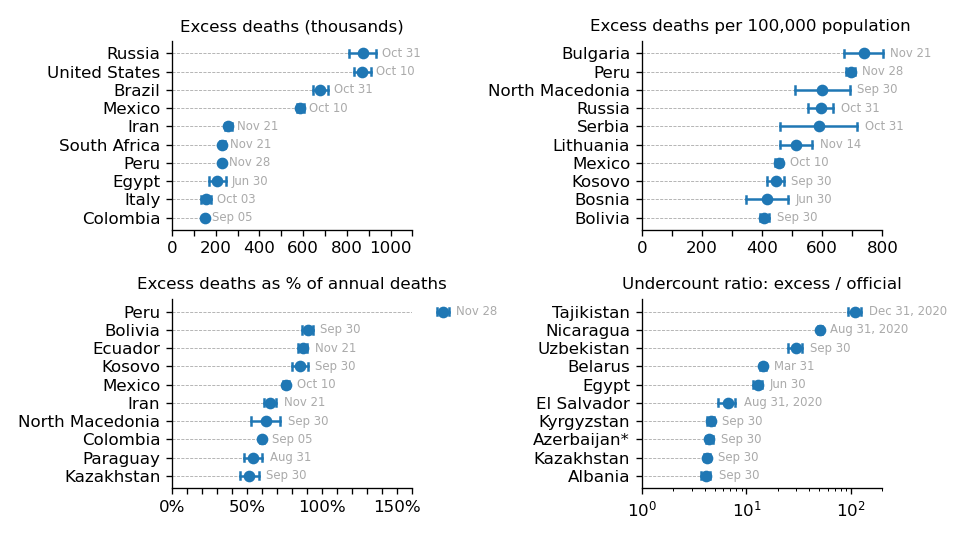

In [30]:
# d = df_official_who[df_official_who['Country']==country]['Cumulative_deaths'].values

fig = plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / 1000
    z[i] = allcountries[c][4] / 1000 * 1.96
    y[i] = x[i] / (official[i]+.001) * officialnow[i]
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,1100] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000,1100],
           ['0', '', '200', '', '400', '', '600', '', '800', '', '1000',''])
plt.title('Excess deaths (thousands)', fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text(x[ind][i]+z[ind][i] + 25, -i, d[:6], c='#aaaaaa', fontsize=7, va='center')

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / pops[i] * 1e+5
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    z[i] = allcountries[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,800]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600,700,800],
           ['0','','200','','400','','600','','800'])
plt.title('Excess deaths per 100,000 population', x=.45, fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]                    
    plt.text(x[ind][i]+z[ind][i] + 25, -i, d, c='#aaaaaa', fontsize=7, va='center')

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = percent_increase(c)
    z[i] = allcountries[c][4] / np.sum(allcountries[c][1]) * 100 * 1.96 ### DANGER ####
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,160] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160],
           ['0%','','','','','50%','','','','','100%','','','','','150%',''])
plt.title('Excess deaths as % of annual deaths', fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text(x[ind][i]+z[ind][i] + 5, -i, d, c='#aaaaaa', fontsize=7, va='center')
    

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / (official[i]+.001)
    z[i] = allcountries[c][4] / (official[i]+.001)
    if np.isnan(undercounts[i]):#allcountries[c][2]/allcountries[c][4] < 2:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [1,200] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official', fontsize=10)
plt.xscale('log')

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text((x[ind][i]+z[ind][i]) * 1.2, -i, d, c='#aaaaaa', fontsize=7, va='center')


sns.despine()
plt.tight_layout()

plt.savefig('img/leaderboard-paper.png', dpi=200)

In [31]:
allcountries2020 = {}

for i, country in enumerate(allcountries):    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
    X = X[X[:,0]<2021]

    if X.shape[0]==0 or (X[-1][1] not in [4,12,52,53]):
        allcountries2020[country] = [[],[1],0,0,0]
        continue
      
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    if country=='Armenia':
        total_excess -= 4000
    if country=='Azerbaijan':
        total_excess -= 4000
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany']:
        heatwave = np.sum(X[(X[:,0]==2020)&(X[:,1]>=32)&(X[:,1]<=34), 2])
        heatwave -= np.sum(baseline[32-1:34+1-1])
        total_excess -= heatwave

    allcountries2020[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

In [32]:
def percent_increase_2020(country, zero_not_signif=False):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries2020[country] 
    d = total_excess/np.sum(baseline)*100
            
    if zero_not_signif and np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000 # for alphabetical sorting
    return d

In [33]:
official2020 = np.zeros(len(allcountries.keys()))

for i,m in enumerate(allcountries.keys()):        
    if m == 'Transnistria':
        # From the Telegram channel https://t.me/novostipmrcom
        # End of June: 1219, May: 1195
        # End of April: 1112, March: 907, February: 689, January: 626, end of 2020: 473
        official2020[i] = 473 
        continue
        
    r = '2021-01-01'
    
    if m == 'Macao':
        official2020[i] = 0
        continue
        
    if m in ['Taiwan', 'Macao', 'Hong Kong']:
        official2020[i] = df_official_jhu[(df_official_jhu['location']==m)
                                      &(df_official_jhu['date']==r)]['total_deaths'].values[0]
    else:
        official2020[i] = df_official_who[(df_official_who['Country']==m)
                                  &(df_official_who['Date_reported']==r)]['Cumulative_deaths'].values[0]

In [34]:
# Export the table

undercounts2020 = np.zeros(countries.size)
for i,country in enumerate(countries):
    if allcountries2020[country][2] < 0:
        undercounts2020[i] = np.nan
    else:
        undercounts2020[i] = allcountries2020[country][2] / official2020[i]

undercounts2020[np.isin(countries, ['Hong Kong', 'Thailand', 'Cuba', 'Monaco'])] = np.nan

with open('excess-mortality-2020.csv','w') as f:
    f.write('Country,Data type,COVID-19 deaths,Excess deaths,'
            'Excess deaths std,t-statistic,Undercount ratio,Excess per 100k,'
            'Excess as % of annual baseline\n')
    
    for i,c in enumerate(allcountries2020):
        until, time_format = until_date(c)
        
        if allcountries2020[c][2] == 0:
            f.write(f'{c},{time_format},{official[i]:.0f},nan,nan,nan,nan,nan,nan\n')
            continue
         
        per100k    = allcountries2020[c][2]/pops[i]*1e+5
        increase   = percent_increase_2020(c)
        
        z = np.abs(allcountries2020[c][2])/allcountries2020[c][4]
            
        f.write(f'{c},{time_format},{official2020[i]:.0f},{allcountries2020[c][2]:.0f},'
                f'{allcountries2020[c][4]:.0f},{z:.1f},{undercounts2020[i]:.2f},{per100k:.1f},{increase:.1f}\n')

<IPython.core.display.Javascript object>


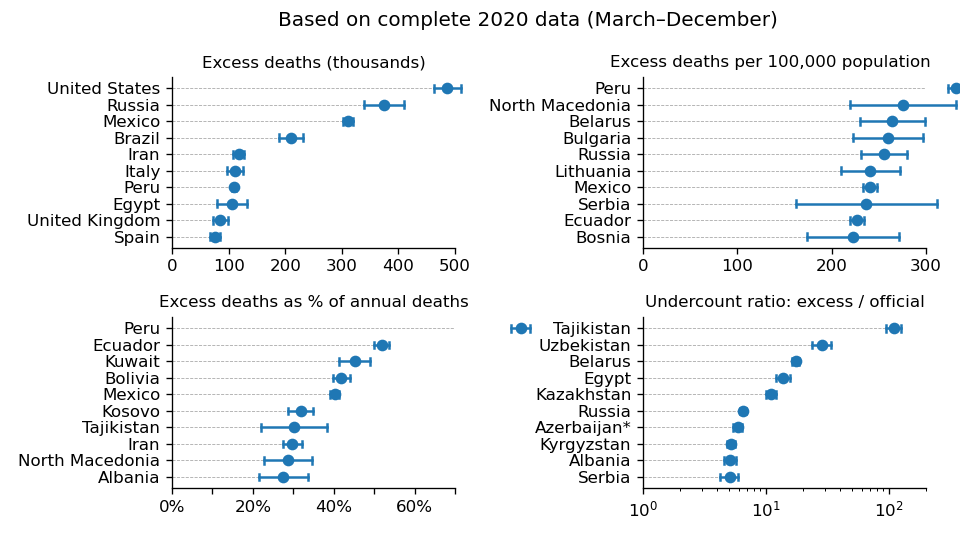

In [35]:
# d = df_official_who[df_official_who['Country']==country]['Cumulative_deaths'].values

plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / 1000
    z[i] = allcountries2020[c][4] / 1000 * 1.96
    y[i] = x[i] / (official[i]+.001) * officialnow[i]
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,500] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500])
plt.title('Excess deaths (thousands)', fontsize=10)

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / pops[i] * 1e+5
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    z[i] = allcountries2020[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,300]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300])
plt.title('Excess deaths per 100,000 population', x=.45, fontsize=10)

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = percent_increase_2020(c)
    z[i] = allcountries2020[c][4] / np.sum(allcountries2020[c][1]) * 100 * 1.96 ### DANGER ####
    y[i] = x[i] / (official[i]+.001)*officialnow[i]
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,70] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70],
           ['0%','','20%','','40%','','60%',''])
plt.title('Excess deaths as % of annual deaths', fontsize=10)
    

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / (official2020[i]+.001)
    z[i] = allcountries2020[c][4] / (official2020[i]+.001)
    if allcountries[c][2]/allcountries[c][4] < 2:
        x[i] = 0
    if c in ['Hong Kong', 'Thailand', 'Cuba','Monaco']:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [1,200] # plt.xlim()
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official', fontsize=10)
plt.xscale('log')

plt.suptitle('Based on complete 2020 data (March–December)', x=.55)
sns.despine()
plt.tight_layout()

plt.savefig('img/leaderboard-paper-2020.png', dpi=200)

In [36]:
# Until the end of 2020

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))

for i,c in enumerate(allcountries):
    d = allcountries[c][0][allcountries[c][0][:,0]==2020,2]
    b = allcountries[c][1]
    if d.size == b.size:
        x[i] = np.sum(d-b) / pops[i] * 1e+5
        y[i] = x[i]
        
    if c=='Armenia':
        y[i] -= 4000 / pops[i] * 1e+5
    if c=='Azerbaijan':
        y[i] -= 4000 / pops[i] * 1e+5
    if c=='Belgium':
        y[i] -= 1539 / pops[i] * 1e+5
    
    z[i] = y[i]
    if pops[i] < 100000:
        z[i] = 0

# ind = np.argsort(x)[::-1][:20]
# for i in ind:
#     c = np.array(list(allcountries.keys()))[i]
#     print(f'{c:15} {x[i]:.0f}')
# print('')

# ind = np.argsort(y)[::-1][:20]
# for i in ind:
#     c = np.array(list(allcountries.keys()))[i]
#     print(f'{c:15} {y[i]:.0f}')
# print('')

print('====== 2020 alone (January--December) ======')
ind = np.argsort(z)[::-1][:20]
for i in ind:
    c = np.array(list(allcountries.keys()))[i]
    print(f'{c:15} {z[i]:.0f}')

====== 2020 alone (January--December) ======
Peru            343
North Macedonia 258
Russia          254
Belarus         253
Bulgaria        242
Mexico          236
Serbia          231
Ecuador         225
Lithuania       221
Armenia         203
Albania         202
Bosnia          201
Bolivia         194
Romania         185
Kosovo          179
Italy           169
Poland          161
Kazakhstan      161
Czechia         152
Azerbaijan      150


In [37]:
# Until the end of 2020

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
e = np.zeros(len(allcountries))

for i,c in enumerate(allcountries):
    d = allcountries[c][0][allcountries[c][0][:,0]==2020,2]
    b = allcountries[c][1]
    if d.size == b.size:
        x[i] = np.sum(d-b) / np.sum(b) * 100
        y[i] = x[i]
        e[i] = np.sum(d-b)
        
    if c=='Armenia':
        y[i] -= 4000 / np.sum(b) * 100
    if c=='Azerbaijan':
        y[i] -= 4000 / np.sum(b) * 100
    if c=='Belgium':
        y[i] -= 1539 / np.sum(b) * 100
    
    z[i] = y[i]
    if pops[i] < 100000:
        z[i] = 0

print('====== 2020 alone (January--December) ======')
ind = np.argsort(z)[::-1][:20]
for i in ind:
    c = np.array(list(allcountries.keys()))[i]
    print(f'{c:15} {z[i]:.0f}%   [{e[i]:.0f} excess]')
print('    Note: tiny countries excluded')

====== 2020 alone (January--December) ======
Peru            89%   [113001 excess]
Ecuador         51%   [39728 excess]
Kuwait          44%   [3211 excess]
Bolivia         43%   [22615 excess]
Mexico          39%   [304840 excess]
Kosovo          34%   [3308 excess]
Tajikistan      30%   [9880 excess]
Iran            29%   [115188 excess]
Azerbaijan      27%   [19201 excess]
North Macedonia 27%   [5378 excess]
Albania         27%   [5813 excess]
Armenia         24%   [10024 excess]
Kyrgyzstan      23%   [7483 excess]
Kazakhstan      23%   [30140 excess]
Russia          21%   [372779 excess]
Colombia        20%   [51192 excess]
Belarus         20%   [23868 excess]
Egypt           19%   [105581 excess]
Bosnia          18%   [6596 excess]
Mayotte         18%   [142 excess]
    Note: tiny countries excluded


In [38]:
c = 'Russia'
d = allcountries[c][0][allcountries[c][0][:,0]==2020,2]
b = allcountries[c][1]
print(np.sum(d))
print(np.sum(b))
print(np.sum(d-b))
print(np.sum(d-b)/np.sum(b))

2138581
1765802.2000006165
372778.79999938357
0.21111016851109


## Extrapolation until today

In [39]:
countries = np.unique(df_official_who['Country'])
stoplist = ['World','Europe','North America','European Union','South America','Asia','Africa']
countries = np.array([c for c in countries if c not in stoplist])
deaths = np.zeros(countries.size)
for i,country in enumerate(countries):
    d = df_official_who[df_official_who['Country']==country]['Cumulative_deaths'].values
    if np.sum(~np.isnan(d)) > 0:
        deaths[i] = np.nanmax(d)
deaths[np.isnan(deaths)]=0
ind = np.argsort(deaths)[::-1][:30]
countries = countries[ind]
deaths = deaths[ind]

df_mine = pd.read_csv('excess-mortality.csv', index_col=None)

undercounts = np.zeros(30) * np.nan
for i,c in enumerate(countries):
    if c in df_mine['Country'].values:
        undercounts[i] = df_mine[df_mine['Country']==c]['Undercount ratio'].values[0]
        
populations = np.zeros(30) * np.nan
for i,c in enumerate(countries):
    populations[i] = df_population[df_population['Country Name']==c]['Value'].values[-1] / 1e+6
    if c=='Russia':
        populations[i] = 146.8

In [40]:
data = [[countries[i],deaths[i],undercounts[i],populations[i]] for i in range(countries.size)]

df_extrap = pd.DataFrame(data, columns=['Country', 'Covid19 deaths, now', 
                                 'Underreporting (excess deaths / covid19 deaths)', 
                                 'Population (mln)'])

# df_extrap['Estimated deaths'] = np.maximum(df_extrap['Underreporting (excess deaths / covid19 deaths)'],1) * df_extrap['Covid19 deaths, now']
df_extrap['Estimated deaths'] = df_extrap['Underreporting (excess deaths / covid19 deaths)'] * df_extrap['Covid19 deaths, now']
df_extrap['Estimated deaths per 100,000'] = df_extrap['Estimated deaths'] / df_extrap['Population (mln)'] / 10

In [41]:
df_extrap

,Country,"Covid19 deaths, now",Underreporting (excess deaths / covid19 deaths),Population (mln),Estimated deaths,"Estimated deaths per 100,000"
0,United States,773083.0,1.22,331.002647,943161.26,284.940700
1,Brazil,614278.0,1.12,212.559409,687991.36,323.670151
2,India,468980.0,NaN,1380.004385,NaN,NaN
3,Mexico,293897.0,2.05,128.932753,602488.85,467.289215
4,Russia,275193.0,3.66,146.800000,1007206.38,686.107888
5,Peru,201108.0,1.14,32.971846,229263.12,695.329949
6,United Kingdom,144810.0,0.93,67.886004,134673.30,198.381540
7,Indonesia,143830.0,NaN,273.523621,NaN,NaN
8,Italy,133739.0,1.19,60.461828,159149.41,263.222954
9,Iran,129711.0,2.00,83.992953,259422.00,308.861626


<IPython.core.display.Javascript object>


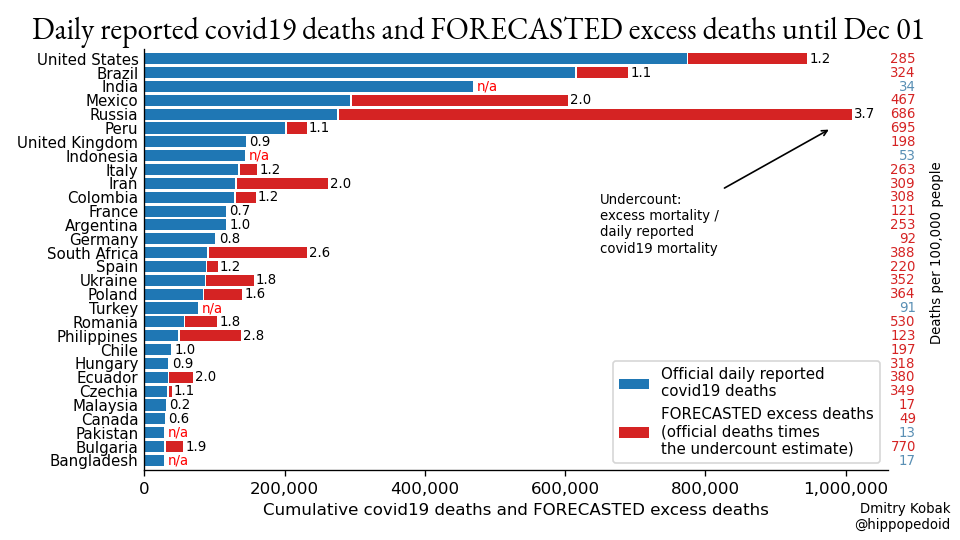

In [42]:
from matplotlib import font_manager as fm
myfont = fm.FontProperties(fname='fonts/static/EBGaramond-Regular.ttf')

fig = plt.figure(figsize=(8, 4.5))

plt.barh(-np.arange(df_extrap.shape[0]), df_extrap['Covid19 deaths, now'], label='Official daily reported\ncovid19 deaths')
delta = df_extrap['Estimated deaths'] - df_extrap['Covid19 deaths, now']
delta[delta<0] = 0
plt.barh(-np.arange(df_extrap.shape[0]), delta, left=df_extrap['Covid19 deaths, now'] + 2000, color='#d52323',
         label='FORECASTED excess deaths\n(official deaths times\nthe undercount estimate)')
         
plt.yticks(-np.arange(df_extrap.shape[0]), [a for a in df_extrap['Country']], fontsize=9)
plt.xlabel('Cumulative covid19 deaths and FORECASTED excess deaths')

# for i in np.where(delta==0)[0]:
#     plt.barh(-i, 2000, left=np.array(df_extrap['Covid19 deaths, now'])[i]-2000, color='k')
for i in np.where(np.isnan(delta))[0]:
    plt.text(np.array(df_extrap['Covid19 deaths, now'])[i] + 5000, -i-.3, 'n/a', color='r', fontsize=8)
for i in range(df_extrap.shape[0]):
    if np.isnan(df_extrap['Estimated deaths'].values[i]):
        plt.text(1_100_000, -i-.3, 
             f"{df_extrap['Covid19 deaths, now'].values[i]/df_extrap['Population (mln)'].values[i]/10:.0f}",
             color='#598fb4', ha='right', fontsize=8)
        continue
    plt.text(np.maximum(df_extrap['Covid19 deaths, now'].values[i], df_extrap['Estimated deaths'].values[i]) + 5000, -i-.3, 
             f"{df_extrap['Underreporting (excess deaths / covid19 deaths)'].values[i]:.1f}",
             color='k', fontsize=8)
    plt.text(1_100_000, -i-.3, 
             f"{df_extrap['Estimated deaths per 100,000'].values[i]:.0f}",
             color='#d52323', ha='right', fontsize=8)
    
plt.title(f'Daily reported covid19 deaths and FORECASTED excess deaths until {datetime.date.today():%b %d}', 
          fontproperties=myfont, fontsize=18, x=.45)

plt.gca().tick_params(axis='y', length=0)

plt.gca().annotate('Undercount:\nexcess mortality /\ndaily reported\ncovid19 mortality',
                   xy=(980_000, -5), xycoords='data',
                   xytext=(650000, -14), textcoords='data',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                   fontsize=8)

plt.text(1_120_000,-14,'Deaths per 100,000 people', rotation=90, va='center', fontsize=8)

plt.ylim([-df_extrap.shape[0]+.3,.7])
# plt.xlim([0,370000])

plt.xticks([0,200_000,400_000,600_000,800_000,1_000_000],
           ['0','200,000','400,000','600,000','800,000','1,000,000'])

sns.despine()
plt.tight_layout()

plt.legend(loc='lower right', fontsize=9)

fig.text(.99,.02, 'Dmitry Kobak\n@hippopedoid', size=8, ha='right')

plt.savefig('img/countries.png', dpi=200)

## Weekly excess and weekly official

In [43]:
# def comparison_jhu(country):
#     X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
#     excess2020 = X[X[:,0]==2020, 2] - baseline
#     excess2021 = X[X[:,0]==2021, 2] - baseline[:np.sum(X[:,0]==2021)]
#     excess = np.concatenate((excess2020, excess2021))

#     officialweekly = np.zeros(53+52) * np.nan
#     for w in range(1,54):
#         r = datetime.datetime.strptime(f'{2020}-W{w:02}-1', "%G-W%V-%w") # Monday
#         r = str(r)[:10]
    
#         ind = (df_official['location']==country) & (df_official['date']==r)
#         if np.any(np.array(ind)):
#             officialweekly[w-1] = df_official[ind]['total_deaths'].values[0]

#     for w in range(1,53):
#         r = datetime.datetime.strptime(f'{2021}-W{w:02}-1', "%G-W%V-%w")
#         r = str(r)[:10]
    
#         ind = (df_official['location']==country) & (df_official['date']==r)
#         if np.any(np.array(ind)):
#             officialweekly[53 + w-1] = df_official[ind]['total_deaths'].values[0]    
    
#     officialweekly[np.where(~np.isnan(officialweekly))[0][0]-1] = 0
#     officialweekly = np.diff(officialweekly)
    
#     if country=='Peru':
#         officialweekly[29] = np.nan
#         officialweekly[32] = np.nan
    
#     return excess, officialweekly

In [44]:
# countries = ['Austria','Belgium','Colombia','France',
#              'Mexico','Netherlands','Peru','Spain',
#              'Sweden','Switzerland','United Kingdom','United States']

# plt.figure(figsize=(10,6))

# for i, country in enumerate(countries):
#     plt.subplot(3,4,i+1)
#     excess, officialweekly = comparison(country)

#     plt.plot(officialweekly, 'k', label='Official', lw=1.5)
#     plt.plot(excess, '#e41a1c', label='Excess', lw=1.5)
    
#     x = excess
#     y = officialweekly[:excess.size]
#     ind = ~np.isnan(x) & ~np.isnan(y)
#     r = np.corrcoef(x[ind], y[ind])[0,1]

#     plt.xlim([0,80])
#     plt.plot([0,80], [0,0], 'k', lw=.75)
#     yl = plt.ylim()
#     plt.plot([53.5,53.5], yl, 'k--', lw=.75)
#     plt.ylim(yl)
#     plt.title(f'{country}, r={r:.2f}')

#     lab1 = ['Jan','','','Apr','','','Jul','','','Oct','','',
#             'Jan','','','Apr','','','']
#     lab2 = [''] * len(lab1)
#     plt.xticks(np.concatenate((np.linspace(0,53.5,13),
#                            np.linspace(53.5 + 52.5/12, 53.5 + 52.5/12 * 6, 6))),
#            lab1 if i>=8 else lab2, 
#                rotation=70)
    
#     if i==0:
#         plt.legend(fontsize=8)

#     if i%4 == 0:
#         plt.ylabel('Weekly deaths')

# sns.despine()
# plt.gcf().align_labels()
# plt.tight_layout()
# plt.savefig('img/tracking_jhu.png', dpi=200)

In [45]:
def comparison_who(country):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    excess2020 = X[X[:,0]==2020, 2] - baseline[:np.sum(X[:,0]==2020)]
    excess2021 = X[X[:,0]==2021, 2] - baseline[:np.sum(X[:,0]==2021)]
    excess = np.concatenate((excess2020, excess2021))
    
    if baseline.size > 50:
        official = np.zeros(53+52) * np.nan
        for w in range(1,54):
            r = datetime.datetime.strptime(f'{2020}-W{w:02}-1', "%G-W%V-%w") # Monday
            r = str(r)[:10]
    
            ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
            if np.any(np.array(ind)):
                official[w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]

        for w in range(1,53):
            r = datetime.datetime.strptime(f'{2021}-W{w:02}-1', "%G-W%V-%w")
            r = str(r)[:10]
    
            ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
            if np.any(np.array(ind)):
                official[53 + w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]    
    
#         official[np.where(~np.isnan(official))[0][0]-1] = 0
#         official = np.concatenate(([0], np.diff(official)))
        official = np.diff(official)
    
#         if country=='Peru':
#             official[29] = np.nan
#             official[32] = np.nan
        if country=='Ecuador':
            official[35] = np.nan
            official[81] = np.nan
            
    elif baseline.size == 12:
        official = np.zeros(12+12) * np.nan
        for w in range(1,13):
#             if w < 12:
            r = f'2020-{w:02}-01'
#             else:
#                 r = f'2021-01-01'
                
            if country in ['Taiwan', 'Macao', 'Hong Kong']:
                ind = (df_official_jhu['location']==country) & (df_official_jhu['date']==r)
                if np.any(np.array(ind)):
                    official[w-1] = df_official_jhu[ind]['total_deaths'].values[0]
                if np.isnan(official[w-1]):
                    official[w-1] = 0
            else:
                ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
                if np.any(np.array(ind)):
                    official[w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]

        for w in range(1,13):
#             if w < 12:
            r = f'2021-{w:02}-01'
#             else:
#                 r = f'2022-01-01'
    
            if country in ['Taiwan', 'Macao', 'Hong Kong']:
                ind = (df_official_jhu['location']==country) & (df_official_jhu['date']==r)
                if np.any(np.array(ind)):
                    official[12 + w-1] = df_official_jhu[ind]['total_deaths'].values[0]
                    if np.isnan(df_official_jhu[ind]['total_deaths'].values[0]):
                        official[12 + w-1] = 0
            else:
                ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
                if np.any(np.array(ind)):
                    official[12 + w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]    
    
#         print(official)
    
#         official[np.where(~np.isnan(official))[0][0]-1] = 0
#         official = np.concatenate(([0], np.diff(official)))
        official = np.diff(official)
#         print(official)
    
    return excess, official

<IPython.core.display.Javascript object>


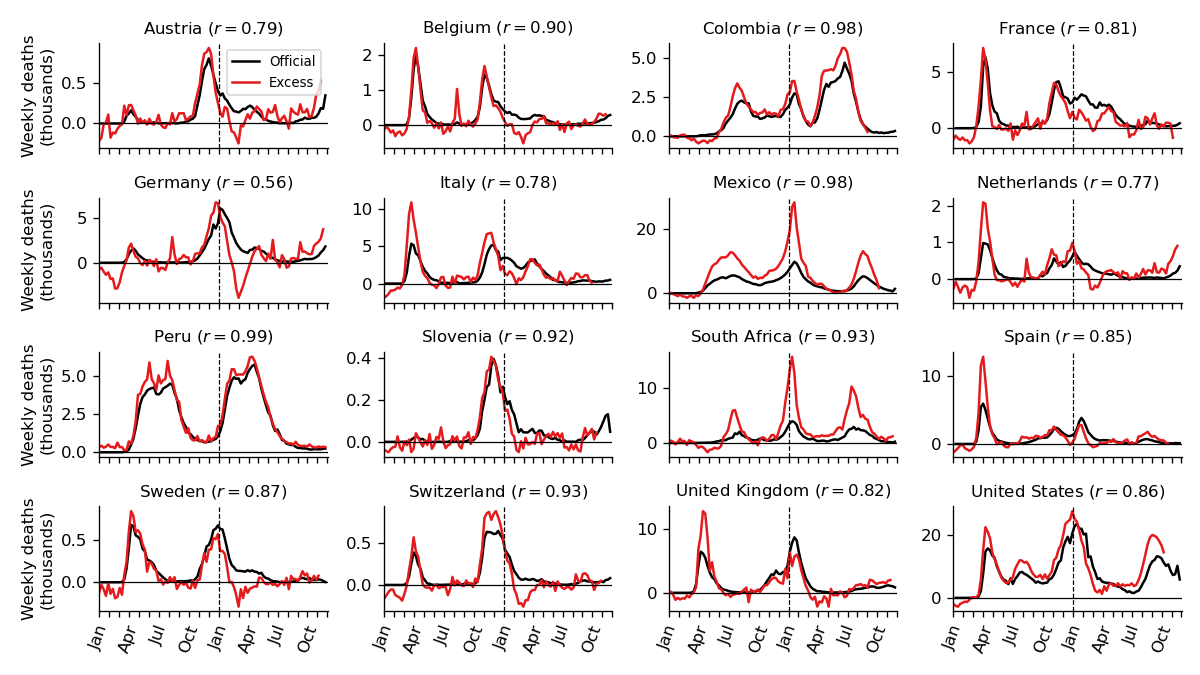

Austria         -- r=0.79, r1=0.77, undercount1: 1.5
Belgium         -- r=0.90, r1=0.98, undercount1: 0.8
Colombia        -- r=0.98, r1=0.99, undercount1: 1.0
France          -- r=0.81, r1=0.89, undercount1: 0.8
Germany         -- r=0.56, r1=0.78, undercount1: 0.0
Italy           -- r=0.78, r1=0.92, undercount1: 1.5
Mexico          -- r=0.98, r1=1.00, undercount1: 2.2
Netherlands     -- r=0.77, r1=0.94, undercount1: 1.3
Peru            -- r=0.99, r1=0.98, undercount1: 1.2
Slovenia        -- r=0.92, r1=0.05, undercount1: -0.1
South Africa    -- r=0.93, r1=0.89, undercount1: 1.6
Spain           -- r=0.85, r1=0.98, undercount1: 1.6
Sweden          -- r=0.87, r1=0.97, undercount1: 1.0
Switzerland     -- r=0.93, r1=0.97, undercount1: 0.8
United Kingdom  -- r=0.82, r1=0.97, undercount1: 1.5
United States   -- r=0.86, r1=0.93, undercount1: 1.3


In [46]:
countries = ['Austria','Belgium','Colombia','France','Germany','Italy',
             'Mexico','Netherlands','Peru','Slovenia','South Africa','Spain',
             'Sweden','Switzerland','United Kingdom','United States']

countries = sorted(countries)

# plt.figure(figsize=(10,7))
fig = plt.figure(figsize=(10, 4.5 * 10/8))

for i, country in enumerate(countries):
    plt.subplot(4,4,i+1)
    excess, officialweekly = comparison_who(country)
    
    plt.plot(officialweekly/1000, 'k', label='Official', lw=1.5)
    plt.plot(excess/1000, '#e41a1c', label='Excess', lw=1.5)
    
    x = excess[get_excess_begin(country,52):]
    y = officialweekly[get_excess_begin(country,52):excess.size]
    ind = ~np.isnan(x) & ~np.isnan(y)
    r = np.corrcoef(x[ind], y[ind])[0,1]
    
    ind = ~np.isnan(x) & ~np.isnan(y) & (np.arange(x.size) < 30-get_excess_begin(country,52))
    r1 = np.corrcoef(x[ind], y[ind])[0,1]
    undercount1 = np.sum(x[ind])/np.sum(y[ind])
    print(f'{country:15} -- r={r:.2f}, r1={r1:.2f}, undercount1: {undercount1:.1f}')

    plt.xlim([0,100])
    plt.plot([0,100], [0,0], 'k', lw=.75)
    yl = plt.ylim()
    plt.plot([52.5,52.5], yl, 'k--', lw=.75)
    plt.ylim(yl)
    plt.title(f'{country} ($r={r:.2f}$)', fontsize=10)

    lab1 = ['Jan','','','Apr','','','Jul','','','Oct','','',
            'Jan','','','Apr','','','Jul','','','Oct','','']
    lab2 = [''] * len(lab1)
    plt.xticks(np.concatenate((np.linspace(0,52.5,13),
                           np.linspace(52.5 + 51.5/12, 52.5 + 51.5/12 * 11, 11))),
           lab1 if i>=12 else lab2, 
               rotation=70)
    
    if i == 0:
        plt.legend(fontsize=8)

    if i % 4 == 0:
        plt.ylabel('Weekly deaths\n(thousands)')

sns.despine()
plt.gcf().align_labels()
plt.tight_layout()
plt.savefig('img/tracking.png', dpi=200)

In [47]:
# correlations = np.zeros(len(allcountries))

# for i,country in enumerate(allcountries):
#     if country not in ['Greenland', 'Transnistria'] and allcountries[country][1].size > 10:
#         print('.', end='')
        
#         excess, officialweekly = comparison_who(country)
        
#         beg = get_excess_begin(country, allcountries[country][1].size)
#         x = excess[beg:]
#         y = officialweekly[beg:excess.size]
#         ind = ~np.isnan(x) & ~np.isnan(y)
#         if np.var(y[ind]) > 0:
#             r = np.corrcoef(x[ind], y[ind])[0,1]
#         else:
#             r = np.nan
#         correlations[i] = r

In [48]:
countries = np.unique(df['country_name'])

for country in ['Germany', 'Austria', 'Belgium', 'France', 'Sweden', 'Slovenia']:
    excess, officialweekly = comparison_who(country)
    delta = np.sum(officialweekly[40:53+16] - excess[40:53+16])
    deltanorm = delta / np.sum(allcountries[country][1]) * 100
    deltapop = delta / pops[countries==country][0] * 100_000

    print(f'{country}: {deltanorm:.1f}%, {deltapop:.0f} per 100k, {delta:.0f} deaths')

Germany: 3.2%, 37 per 100k, 31301 deaths
Austria: 2.3%, 22 per 100k, 1959 deaths
Belgium: 5.8%, 56 per 100k, 6460 deaths
France: 4.3%, 40 per 100k, 26288 deaths
Sweden: 5.4%, 49 per 100k, 4969 deaths
Slovenia: 3.3%, 33 per 100k, 695 deaths


In [49]:
undercounts = np.zeros(countries.size)
for i,country in enumerate(countries):
    if allcountries[country][2]/np.sum(allcountries[country][1])*100 < 2:
        undercounts[i] = np.nan
    else:
        undercounts[i] = allcountries[country][2] / official[i]

undercounts[np.isin(countries, ['Hong Kong', 'Cuba', 'Bermuda', 'Antigua and Barbuda',
                                'Finland', 'Cyprus', 'Iceland', 'Japan', 'Singapore',
                                'Denmark'])] = np.nan

correlations = np.zeros(len(allcountries))

for i,country in enumerate(countries):
    if country not in ['Greenland', 'Transnistria'] and allcountries[country][1].size > 10:
        excess, officialweekly = comparison_who(country)
        
        beg = get_excess_begin(country, allcountries[country][1].size)
        x = excess[beg:]
        y = officialweekly[beg:excess.size]
        ind = ~np.isnan(x) & ~np.isnan(y)
        r = np.corrcoef(x[ind], y[ind])[0,1]
        correlations[i] = r
        
        fig = plt.figure(figsize=(8 * 5/8, 4.5 * 5/8))

        plt.plot(excess, 'r.-', label='Excess')
        plt.plot(officialweekly, 'k', label='Reported')
        
        plt.legend(frameon=False)

        if allcountries[country][1].size>50:
            plt.xlim([0,104])
            plt.plot([0,104], [0,0], 'k', lw=.75)
            yl = plt.ylim()
            plt.plot([52.5,52.5], yl, 'k--', lw=.75)
            plt.ylim(yl)
            plt.xlabel('Weeks (from the beginning of 2020)')
            plt.ylabel('Weekly deaths')
        else:
            plt.xlim([0,24])
            plt.plot([0,24], [0,0], 'k-', lw=.75)
            yl = plt.ylim()
            plt.plot([11.5,11.5], yl, 'k--', lw=.75)
            plt.ylim(yl)
            plt.xlabel('Months (from the beginning of 2020)')
            plt.ylabel('Monthly deaths')
        
        plt.title(f'{country}, $r={r:.2f}$, undercount$={undercounts[i]:.1f}$')

        sns.despine()
        plt.tight_layout()
        plt.savefig(f'img/tracking/{country}.png', dpi=200)

from IPython.display import clear_output
clear_output()

In [50]:
# ts = np.zeros(len(allcountries))
# for i,country in enumerate(allcountries):
#     ts[i] = allcountries[country][2] / allcountries[country][4]

In [51]:
# correlations0 = correlations.copy()
# correlations0[np.isnan(correlations0)] = 0

# plt.figure(figsize=(6.5, 6))
# plt.scatter(ts, correlations0, s=5)
# plt.xlabel('z')
# plt.ylabel('Pearson correlation')

# plt.plot([2,2],[-.5,1], 'k--', lw=.75)
# plt.plot([0,0],[-.5,1], 'k--', lw=.75)
# plt.ylim([-.5,1])

# for i,country in enumerate(allcountries):
#     plt.text(ts[i], correlations0[i], country, fontsize=6)

# sns.despine()
# plt.tight_layout()
# plt.savefig('img/correlations.png', dpi=200)

In [52]:
# clist = np.array(list(allcountries.keys()))
# clist[(ts>60) & (correlations<.2)]

In [53]:
# for i,country in enumerate(allcountries):
#     t = np.abs(allcountries[country][2] / allcountries[country][4])
#     if (t>2) and (t<3):
#         print(f'{country:15} -- {t:.2}, {correlations[i]:.2}')

# print('')

# for i,country in enumerate(allcountries):
#     t = np.abs(allcountries[country][2] / allcountries[country][4])
#     if (t>1) and (t<2):
#         print(f'{country:15} -- {t:.2}, {correlations[i]:.2}')

## Plot trends

In [54]:
for c in countries:
    X = allcountries[c][0]
    b = allcountries[c][1]

    if b.size>50:
        resolution = 'Weekly'
    elif b.size==12:
        resolution = 'Monthly'
    else:
        resolution = 'Quarterly'

    fig = plt.figure(figsize=(8, 4.5))
    
    plt.subplot(121)
    for y in range(2015, 2022):
        plt.plot(X[X[:,0]==y,2], label=y)
    plt.plot(b, 'k', label='baseline')
    plt.legend()
    plt.ylabel(f'{resolution} deaths')
    plt.title(c)

    plt.subplot(122)
    s = np.zeros(7)
    for y in range(2015, 2022):
        s[y-2015] = np.sum(X[X[:,0]==y,2]) / np.sum(X[:,0]==y)    
    plt.plot(np.arange(2015,2022), s, '.-')
    plt.plot(2020, np.mean(b), 'k.')
    plt.plot(2021, np.mean(b), 'k.')
    plt.ylabel(f'Mean {resolution.lower()} deaths')
    plt.xlabel('Year')
    plt.title(c)

    sns.despine()
    plt.tight_layout()

    plt.savefig(f'img/trends/{c}.png', dpi=200)
    
from IPython.display import clear_output
clear_output()